### RRT Star

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import shapely as sp
import matplotlib.pyplot as plt
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from shapely import Polygon
from rrt import RapidlyExploringRandomTreesStarClass
from util import rot_mtx,is_point_feasible,is_point_to_point_connectable
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("shapely version:[%s]"%(sp.__version__))

networkx version:[3.0]
shapely version:[2.0.1]


### Instantiate RRT*

In [2]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-2D',point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
    goal_select_rate=0.05,steer_len_max=0.1,search_radius=0.2,norm_ord=2,
    n_node_max=2000,TERMINATE_WHEN_GOAL_REACHED=False)
print ("[%s] instantiated."%(RRT.name))

[RRT-Star-2D] instantiated.


### Set obstacles

In [3]:
# Set obstacles (fixed)
RANDOM_OBSTACLES = True
if RANDOM_OBSTACLES:
    np.random.seed(seed=0)
    width,height,n_obs = 0.1,1.0,8
    box = np.array([[-width/2,-height/2],[width/2,-height/2],[width/2,height/2],[-width/2,height/2]])
    obs_list = []
    for _ in range(n_obs):
        box_translate = box@rot_mtx(360*np.random.rand()) + (-1+2*np.random.rand(1,2))
        obs_list.append(Polygon(box_translate))
else:
    obs_list = []
    obs_list.append(Polygon([(0.25,0.5),(0.25,-0.5),(0.5,-0.5),(0.5,0.5)]))
    obs_list.append(Polygon([(0.5,0.5),(-0.5,0.5),(-0.5,0.25),(0.5,0.25)]))
    obs_list.append(Polygon([(-0.5,0.5),(-0.5,-0.5),(-0.25,-0.5),(-0.25,0.5)]))
    obs_list.append(Polygon([(0.25,-0.5),(1.0,-0.5),(1.0,-0.25),(0.25,-0.25)]))
print ("Ready.")

Ready.


### Loop

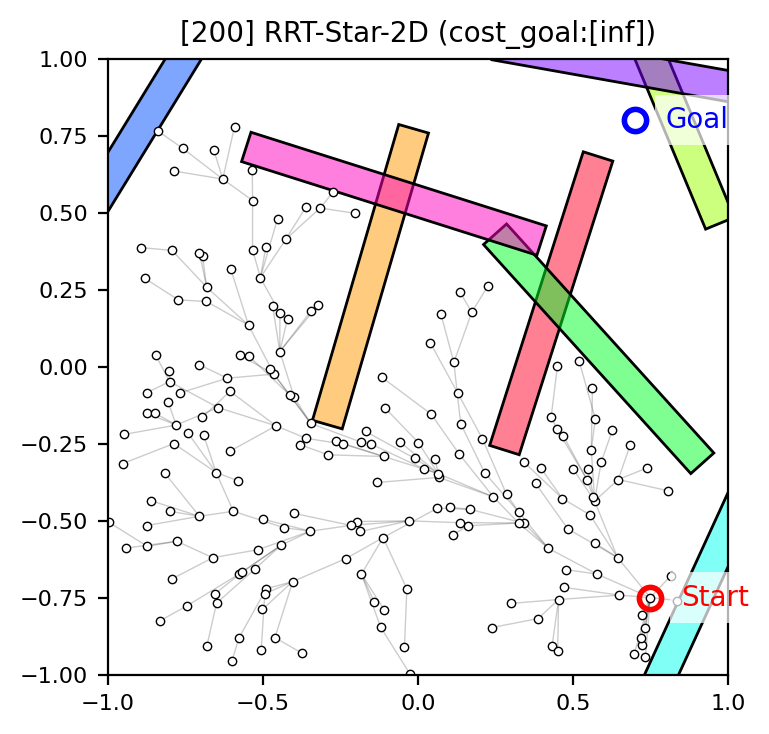

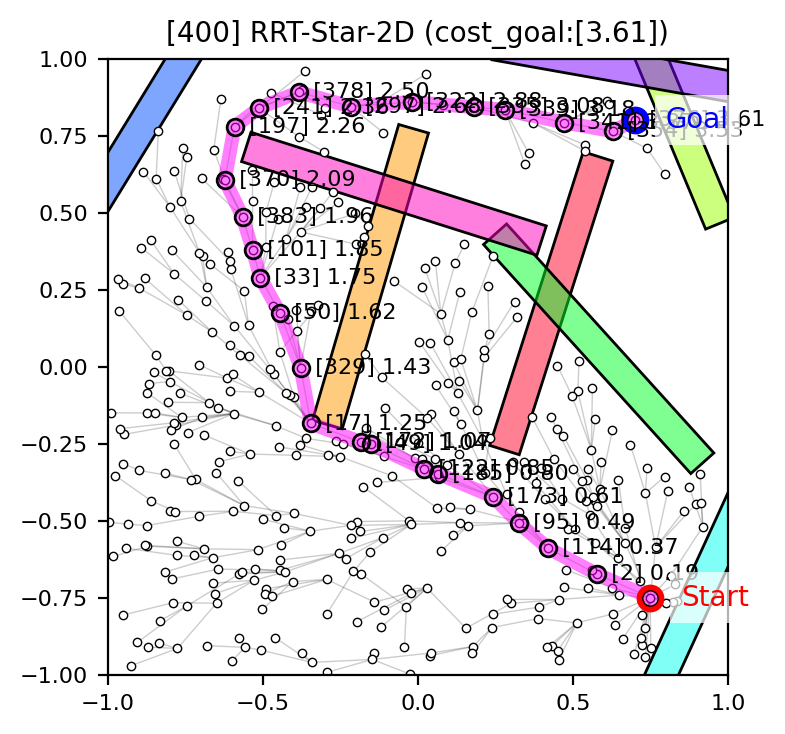

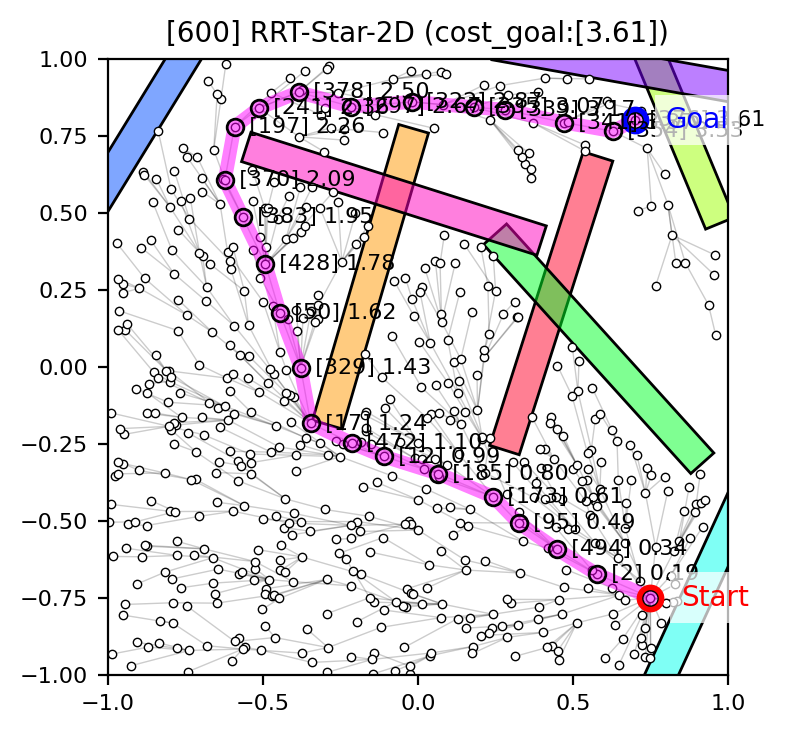

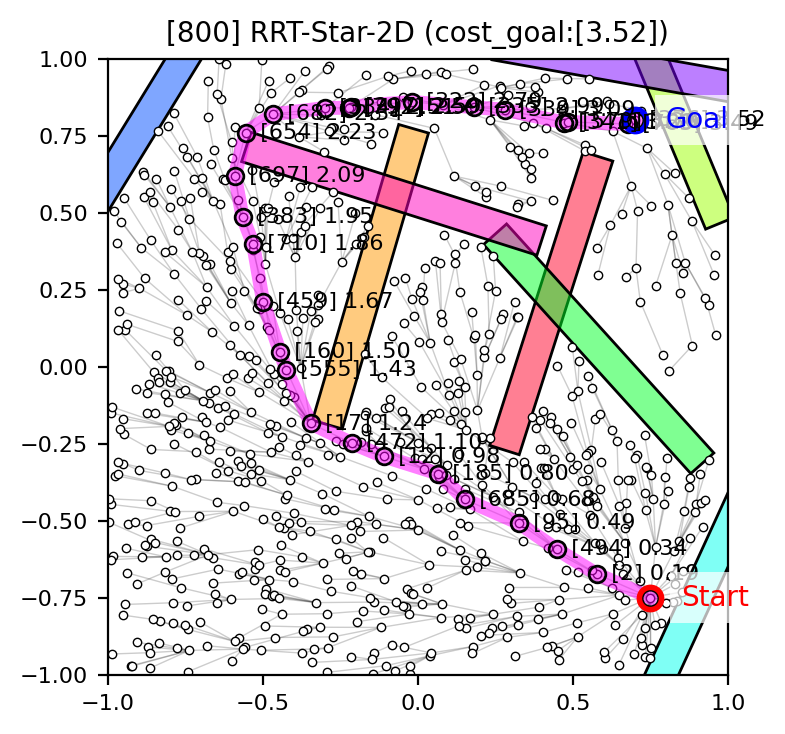

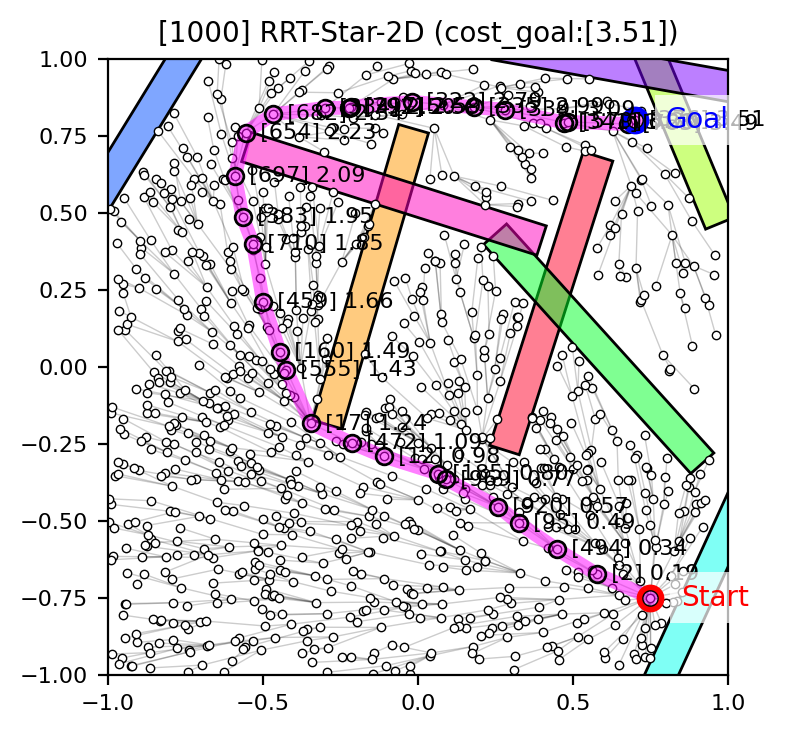

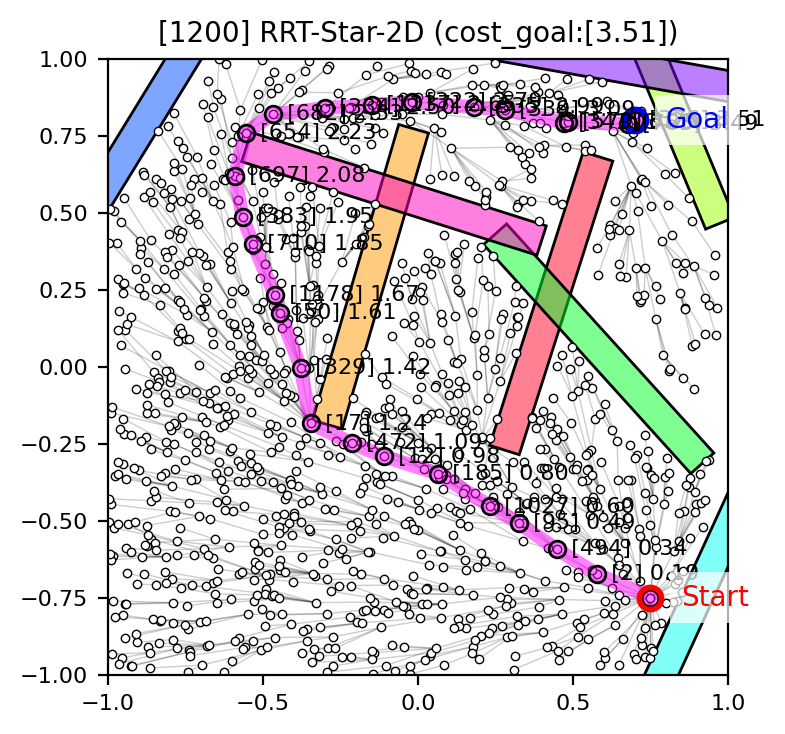

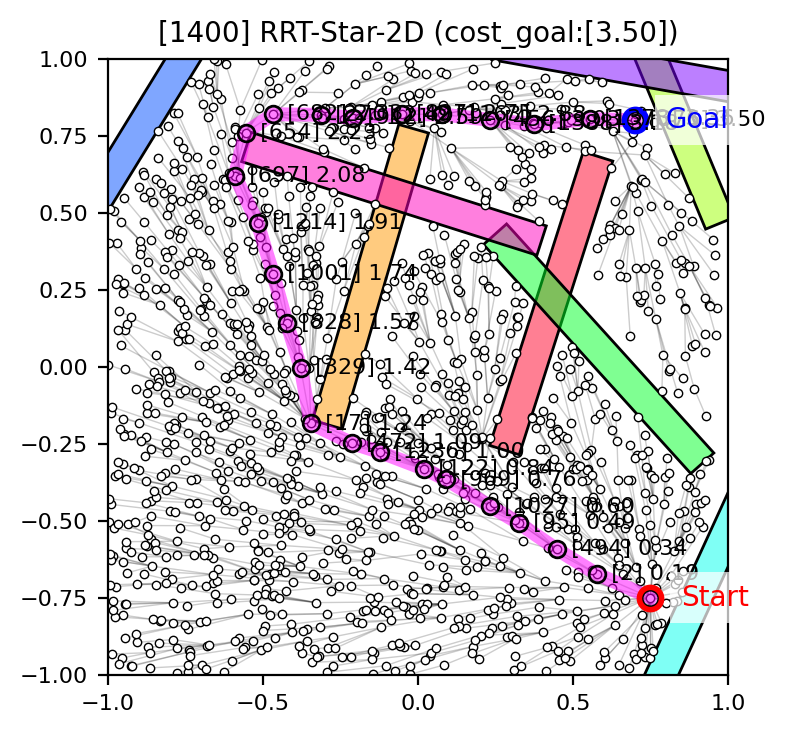

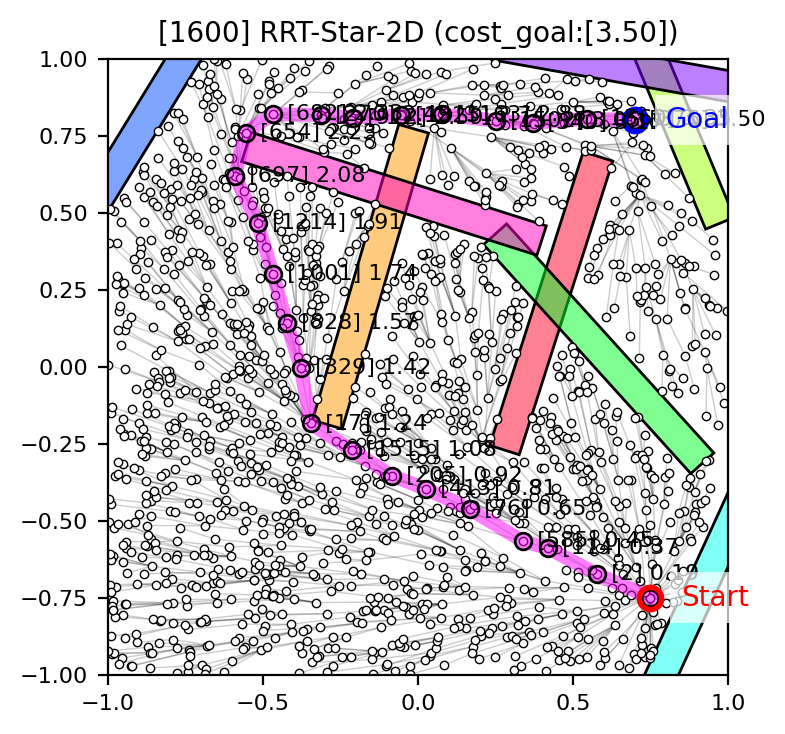

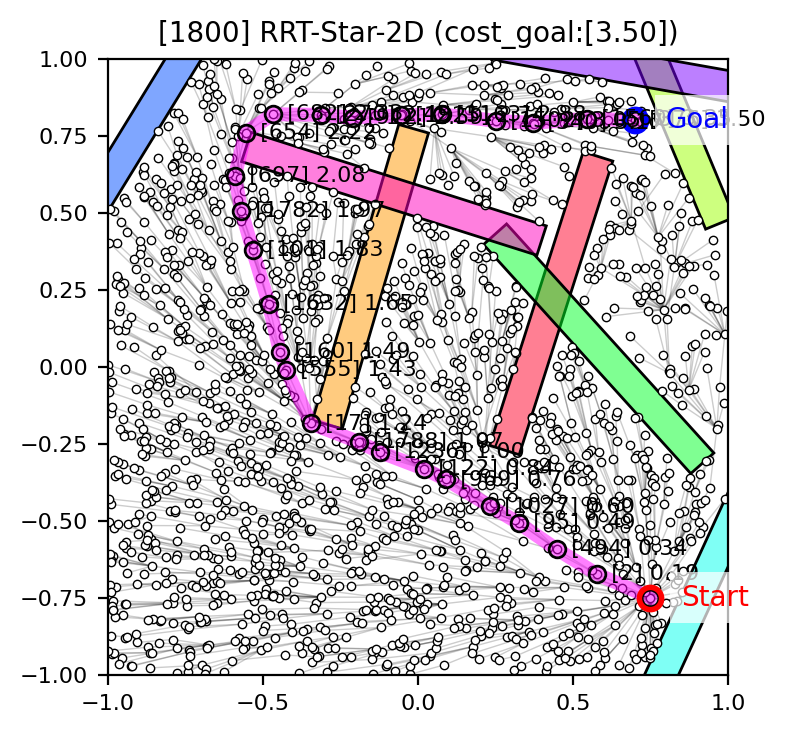

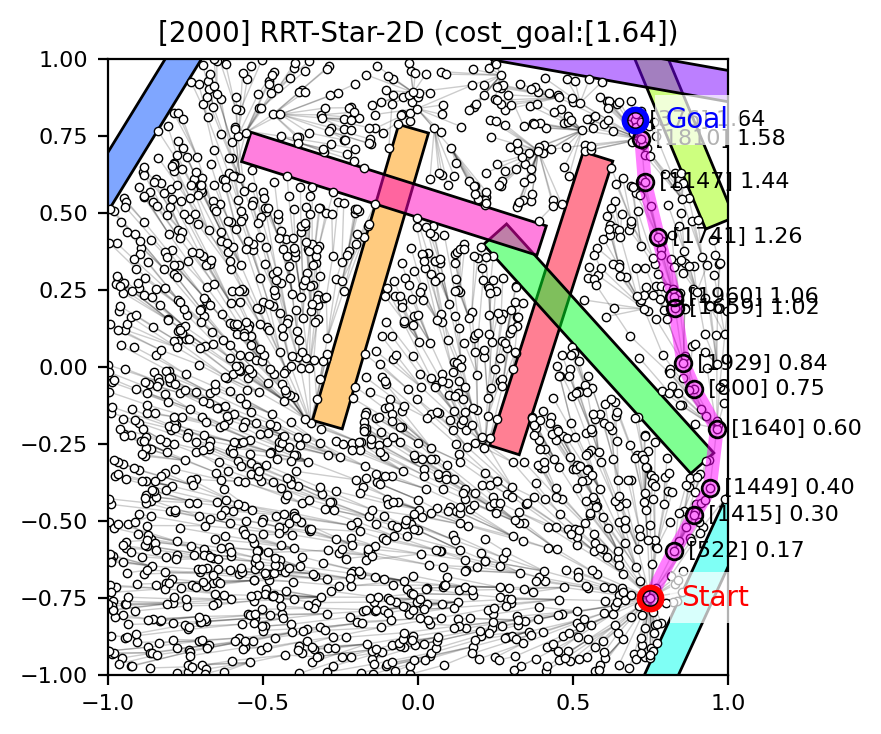

Done.


In [4]:
point_root,point_goal=np.array([0.75,-0.75]),np.array([0.7,0.8])
RRT.init_rrt_star(point_root=point_root,point_goal=point_goal)
while (RRT.get_n_node() <= RRT.n_node_max) and RRT.increase_loop_cnt():
    
    # Randomly sample a point
    while True:
        if np.random.rand() <= RRT.goal_select_rate: point_sample = RRT.point_goal # select goal
        else: point_sample = RRT.sample_point() # random sampling
        if is_point_feasible(point_sample,obs_list): break

    # Get the nearest node
    node_nearest = RRT.get_node_nearest(point_sample)
    
    # Steering towards 'point_sample'
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    if point_new is None: continue # if the steering point is feasible

    # Rewiring 
    if is_point_feasible(point_new,obs_list) \
        and is_point_to_point_connectable(RRT.get_node_point(node_nearest),point_new,obs_list):
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)

        # For all 'node_near'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(point_near,point_new,obs_list):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        
        # Rewire
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            cost_check = cost_new+RRT.get_dist(point_near,point_new)
            if (cost_check < cost_near) and \
                is_point_to_point_connectable(point_near,point_new,obs_list):
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)

    # Re-update cost of all nodes
    RRT.update_nodes_cost(VERBOSE=False)

    # Debug 
    if (RRT.get_n_node() % (RRT.n_node_max//10)) == 0:
        node_goal = RRT.get_node_goal()
        if node_goal is not None: cost_goal = RRT.get_node_cost(node_goal)
        else: cost_goal = np.inf
        titlestr = '[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal)
        RRT.plot_tree_custom(
            figsize=(4,4),xlim=(RRT.point_min[0],RRT.point_max[0]),ylim=(RRT.point_min[1],RRT.point_max[1]),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,startbbalpha=0.7,start_xoffset=0.1,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,goalbbalpha=0.7,goal_xoffset=0.1,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=8,
            obs_list=obs_list,obsrgba=None,obsec='k',
            textfs=8,titlestr=titlestr,titlefs=10,
            PLOT_FULL_TEXT=False)

    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if (dist_to_goal < 1e-6) and RRT.TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
print ("Done.")

### Get path to goal

In [5]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
for node_idx,node in enumerate(path_node_list):
    print ("[%d/%d] node:[%d] point:%s cost:[%.2f]"%
           (node_idx,len(path_node_list),node,RRT.get_node_point(node),RRT.get_node_cost(node)))

[0/13] node:[0] point:[ 0.75 -0.75] cost:[0.00]
[1/13] node:[522] point:[ 0.83 -0.6 ] cost:[0.17]
[2/13] node:[1415] point:[ 0.89 -0.48] cost:[0.30]
[3/13] node:[1449] point:[ 0.94 -0.4 ] cost:[0.40]
[4/13] node:[1640] point:[ 0.96 -0.2 ] cost:[0.60]
[5/13] node:[800] point:[ 0.89 -0.07] cost:[0.75]
[6/13] node:[1929] point:[0.86 0.01] cost:[0.84]
[7/13] node:[1659] point:[0.83 0.19] cost:[1.02]
[8/13] node:[1960] point:[0.83 0.23] cost:[1.06]
[9/13] node:[1741] point:[0.78 0.42] cost:[1.26]
[10/13] node:[1147] point:[0.73 0.6 ] cost:[1.44]
[11/13] node:[1810] point:[0.72 0.74] cost:[1.58]
[12/13] node:[376] point:[0.7 0.8] cost:[1.64]


### Plot

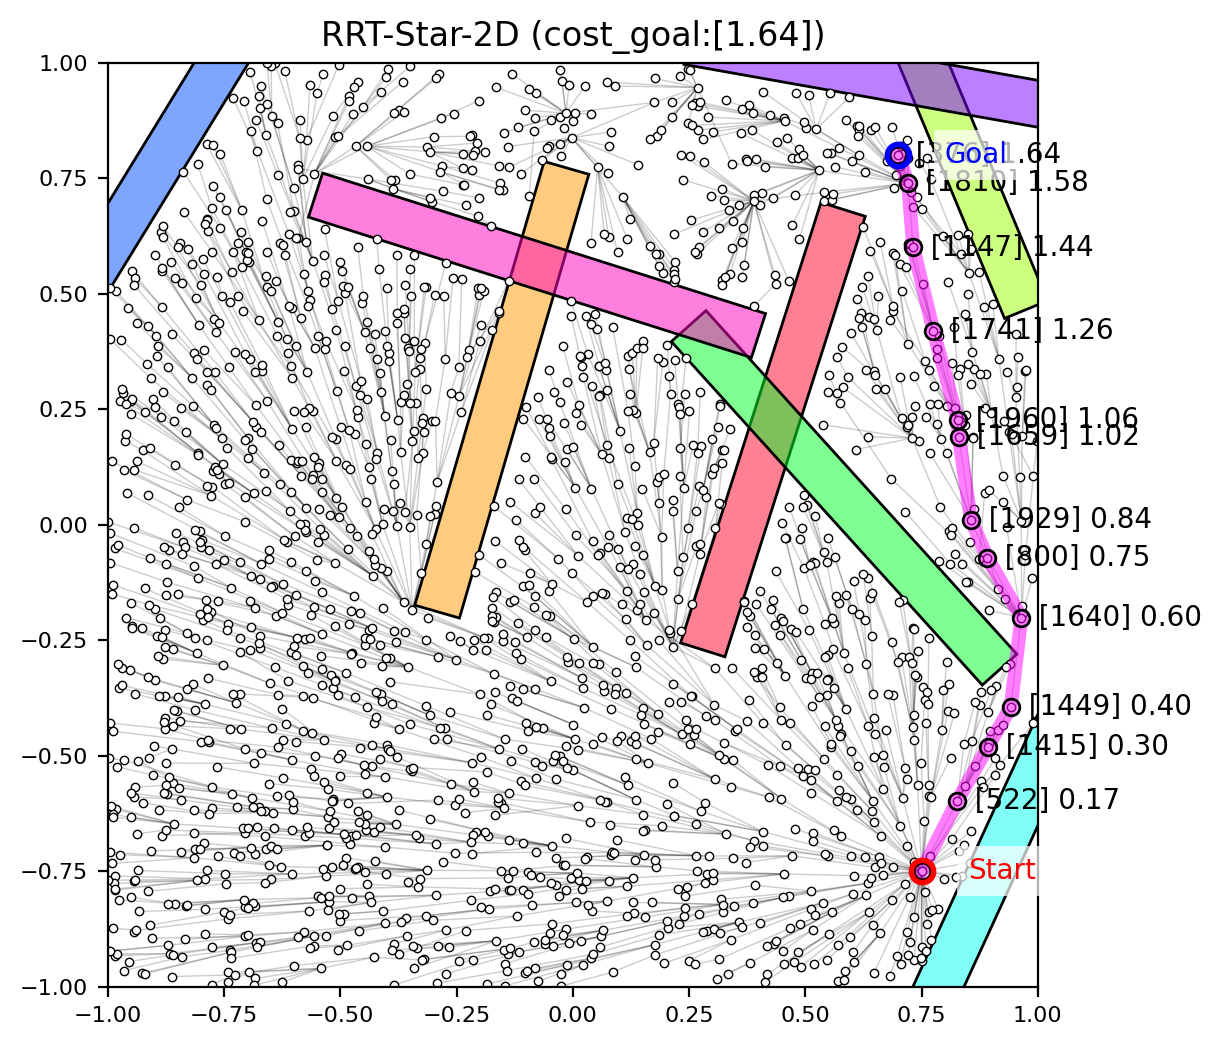

In [6]:
titlestr = '%s (cost_goal:[%.2f])'%(RRT.name,cost_goal)
RRT.plot_tree_custom(
    figsize=(6,6),xlim=(RRT.point_min[0],RRT.point_max[0]),ylim=(RRT.point_min[1],RRT.point_max[1]),
    nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
    edgergba=[0,0,0,0.2],edgelw=1/2,
    startrgb=[1,0,0],startms=8,startmew=2,startfs=10,startbbalpha=0.7,start_xoffset=0.1,
    goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,goalbbalpha=0.7,goal_xoffset=0.1,
    pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=10,
    obs_list=obs_list,obsrgba=None,obsec='k',
    textfs=8,titlestr=titlestr,titlefs=12,
    PLOT_FULL_TEXT=False)